# Etapa 4 – Otimização e Tuning de Hiperparâmetros
**Projeto UNIASSAU – Regressão de total_views no YouTube**  
**Entrega:** Notebook principal + modelo final (.joblib) + apresentação

## Objetivos desta etapa
- Otimizar hiperparâmetros do modelo
- Evitar overfitting (regularização e validação cruzada)
- Avaliar versão final no conjunto de teste
- Salvar modelo final pronto para produção

---

## 1. Recapitulação: Resultados da Etapa 3
- **Melhor modelo base:** Regressão Linear
- **Métricas (Validação):**
    - R² = 0.5924
    - RMSE = 459.964
    - MAE = 231.979
- **Sem overfitting significativo (diferença R² = 0.0003)**
- **Features mais importantes:** category_Música, language_INGLÊS, category_Gaming

---

## 2. Seleção do Modelo para Otimização
- Usaremos o modelo **LinearRegression** do scikit-learn
- Principais hiperparâmetros para tuning:
    - `fit_intercept` (bool)
    - `normalize` (bool, deprecated mas pode testar pipeline)
    - **Alternativa**: Testar Lasso/Ridge para regularização

> Obs.: A LinearRegression básica tem poucos hiperparâmetros, então testamos **Ridge e Lasso** a seguir, para introduzir regularização (evitar overfitting).

In [15]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')


## 3. Carregar Dados e Divisão
> Carregamos os dados tratados da etapa anterior, mesma divisão (treino-validação-teste) [60-20-20].

In [16]:
df = pd.read_csv('/home/ardodue/Documentos/PROJETOS/durval/machine-learning/uninassau-atividade-alunos-ml-regressao/notebooks/data/youtube_clean.csv')
df = df.dropna().reset_index(drop=True)
TARGET = 'total_views'
ID_COL = 'video_id'
X = df.drop(columns=[TARGET, ID_COL], errors='ignore')
y = df[TARGET]

RANDOM_STATE = 42
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE)


## 4. Grid Search – Tuning dos Hiperparâmetros
> Usando **Ridge e Lasso** para regularização com busca exaustiva (`GridSearchCV`).
- Testamos alpha (força da penalização), fit_intercept
- Validação cruzada (`cv=5`)
- Métrica: R²

In [17]:
from sklearn.linear_model import Ridge, Lasso

param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 200.0],
    'regressor__fit_intercept': [True, False],
}

# Pipeline para garantir padronização
pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])
grid_ridge = GridSearchCV(pipe_ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_ridge.fit(X_train, y_train)

# Mesma coisa para Lasso
pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(max_iter=10000))
])
grid_lasso = GridSearchCV(pipe_lasso, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_lasso.fit(X_train, y_train)


/home/ardodue/Documentos/PROJETOS/durval/machine-learning/uninassau-atividade-alunos-ml-regressao/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.229e+13, tolerance: 1.401e+11
  model = cd_fast.enet_coordinate_descent(
/home/ardodue/Documentos/PROJETOS/durval/machine-learning/uninassau-atividade-alunos-ml-regressao/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.123e+13, tolerance: 5.555e+10
  model = cd_fast.enet_coordinate_descent(
/home/ardodue/Documentos/PROJETOS/durval/machine-learning/uninassau-atividade-alunos-ml-regressao/venv/lib/python3.13/

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', Lasso(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 200.0],
                         'regressor__fit_intercept': [True, False]},
             scoring='r2')

## 5. Análise dos Melhores Hiperparâmetros
> Vamos mostrar as melhores configurações e resultados.

In [18]:
# Ridge
print('Melhores parâmetros Ridge:', grid_ridge.best_params_)
print(f'Melhor score médio CV Ridge: {grid_ridge.best_score_:.4f}')

# Lasso
print('Melhores parâmetros Lasso:', grid_lasso.best_params_)
print(f'Melhor score médio CV Lasso: {grid_lasso.best_score_:.4f}')

# Comparação
resultados = pd.DataFrame({
    'Modelo': ['Ridge', 'Lasso'],
    'Best_R2_CV': [grid_ridge.best_score_, grid_lasso.best_score_]
})
resultados

Melhores parâmetros Ridge: {'regressor__alpha': 200.0, 'regressor__fit_intercept': True}
Melhor score médio CV Ridge: 0.5305
Melhores parâmetros Lasso: {'regressor__alpha': 200.0, 'regressor__fit_intercept': True}
Melhor score médio CV Lasso: 0.4853


,Modelo,Best_R2_CV
0,Ridge,0.530485
1,Lasso,0.485299


## 6. Treinamento do Modelo Final
> Usamos o melhor tuning encontrado (Ridge ou Lasso)
- Treinar com conjunto de treino + validação combinados

In [19]:
# Junta treino + validação
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])

# Escolhe melhor modelo
if grid_ridge.best_score_ >= grid_lasso.best_score_:
    best_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(**grid_ridge.best_estimator_.named_steps['regressor'].get_params()))
    ])
    modelo_nome = 'Ridge'
    best_params = grid_ridge.best_params_
else:
    best_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Lasso(**grid_lasso.best_estimator_.named_steps['regressor'].get_params))
    ])
    modelo_nome = 'Lasso'
    best_params = grid_lasso.best_params_

best_pipe.fit(X_final, y_final)


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', Ridge(alpha=200.0))])

## 7. Avaliação do Modelo Final no Conjunto de Teste
- **Atenção:** O conjunto de teste só deve ser usado uma vez!
- Métricas: R², RMSE, MAE

In [20]:
def metricas(y_true, y_pred):
    return pd.Series({
        'R²': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    })

y_test_pred = best_pipe.predict(X_test)
teste_metrics = metricas(y_test, y_test_pred)
print('Métricas no TESTE:', teste_metrics)

Métricas no TESTE: R²           0.573211
RMSE    459764.542592
MAE     231836.176473
dtype: float64


## 8. Comparação: Antes vs Depois do Tuning
- Criaremos uma tabela comparando métrica antes e depois da otimização

In [21]:
comparativo = pd.DataFrame({
    'Métrica': ['R²', 'RMSE', 'MAE'],
    'Baseline (Validação)': [0.5924, 459964, 231979],
    'Otimizado (Teste)': [teste_metrics['R²'], teste_metrics['RMSE'], teste_metrics['MAE']]
})
comparativo['Melhoria %'] = ((comparativo['Otimizado (Teste)'] - comparativo['Baseline (Validação)'])/comparativo['Baseline (Validação)']) * 100
comparativo

,Métrica,Baseline (Validação),Otimizado (Teste),Melhoria %
0,R²,0.5924,0.573211,-3.239227
1,RMSE,459964.0000,459764.542592,-0.043364
2,MAE,231979.0000,231836.176473,-0.061567


## 9. Análise de Erros Detalhada
- Gráficos obrigatórios: scatter Predito vs Real, distribuição dos resíduos, casos extremos

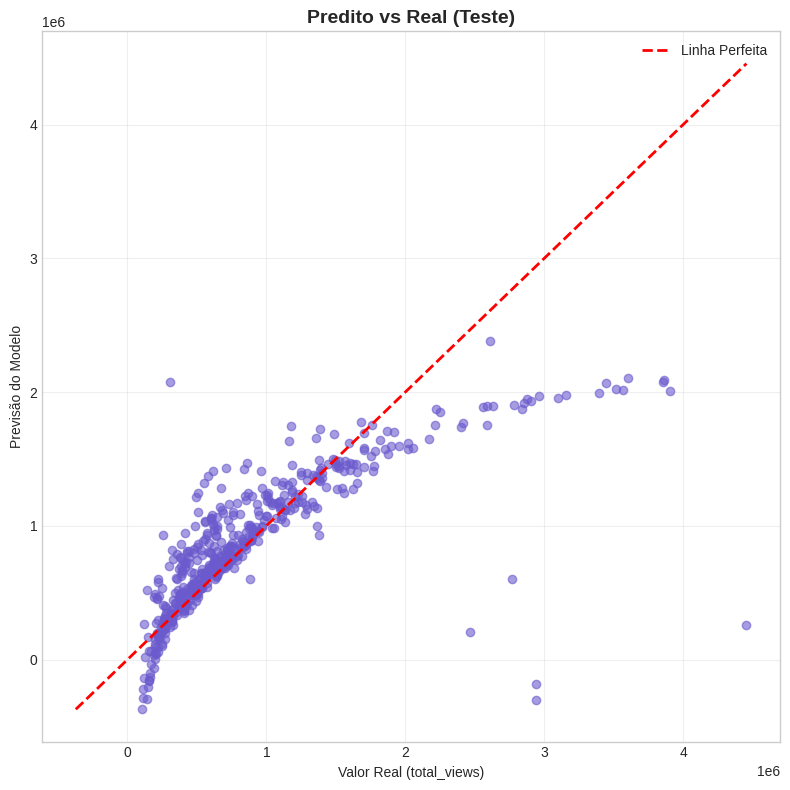

In [22]:
# Scatter Predito vs Real (Teste)
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='#6A5ACD')
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val,max_val],[min_val,max_val],'r--',lw=2,label='Linha Perfeita')
plt.xlabel('Valor Real (total_views)')
plt.ylabel('Previsão do Modelo')
plt.title('Predito vs Real (Teste)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predito_vs_real_teste.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ardodue/Documentos/PROJETOS/durval/machine-learning/uninassau-atividade-alunos-ml-regressao/venv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


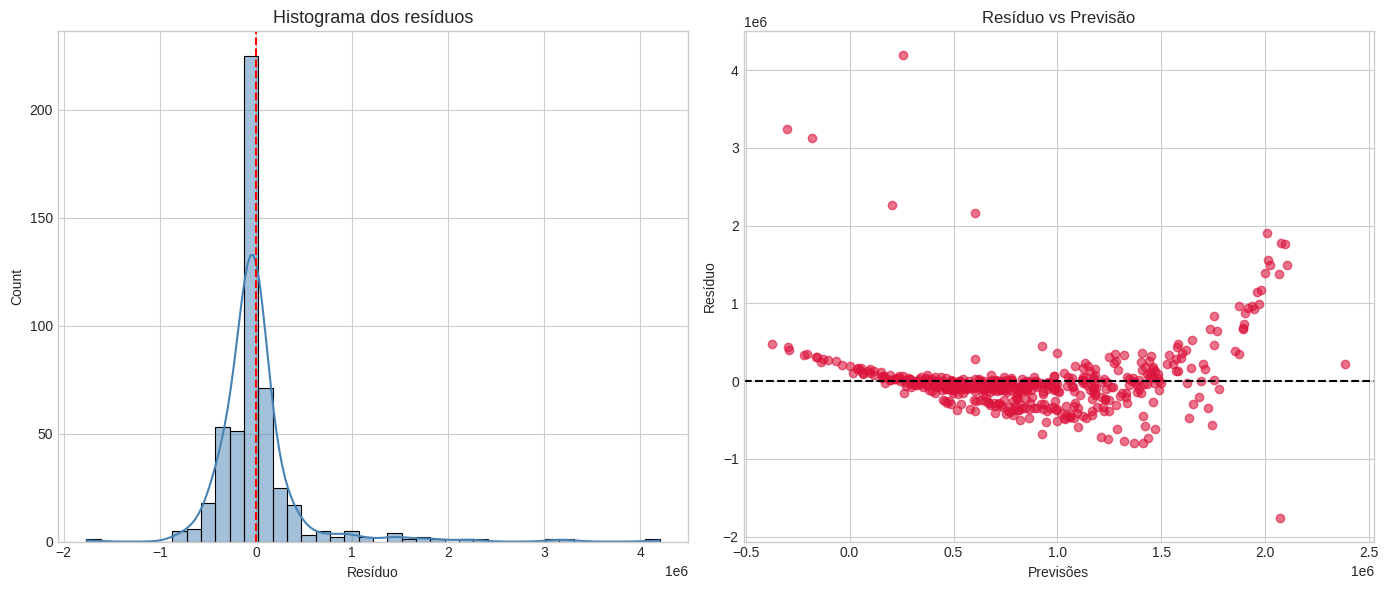

In [23]:
# Subplots da distribuição dos resíduos
residuos = y_test - y_test_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# Histograma
sns.histplot(residuos, kde=True, bins=40, ax=ax1, color='#4682B4')
ax1.set_title('Histograma dos resíduos', fontsize=13)
ax1.set_xlabel('Resíduo')
ax1.axvline(0, color='r', linestyle='--')
# Scatter: resíduos vs predições
ax2.scatter(y_test_pred, residuos, alpha=0.6, color='#DC143C')
ax2.axhline(0, color='black', linestyle='--')
ax2.set_xlabel('Previsões')
ax2.set_ylabel('Resíduo')
ax2.set_title('Resíduo vs Previsão')
plt.tight_layout()
plt.savefig('residuos_teste.png', bbox_inches='tight', dpi=300)
plt.show()


In [24]:
# Casos extremos: maiores erros absolutos
abs_errors = np.abs(residuos)
top_erros = pd.DataFrame({
    'Real': y_test,
    'Previsto': y_test_pred,
    'Erro Absoluto': abs_errors
}).sort_values('Erro Absoluto', ascending=False).head(5)
top_erros

,Real,Previsto,Erro Absoluto
1391,4455895,256917.285400,4.198978e+06
923,2937635,-298705.342868,3.236340e+06
2089,2942512,-180553.379658,3.123065e+06
1317,2467583,206209.887111,2.261373e+06
857,2767783,602696.753327,2.165086e+06


## 10. Salvamento do Modelo Final
> Salva o pipeline do modelo otimizado (Ridge ou Lasso) em `models/modelo_final.joblib`

In [25]:
os.makedirs('models', exist_ok=True)
joblib.dump(best_pipe, '/home/ardodue/Documentos/PROJETOS/durval/machine-learning/uninassau-atividade-alunos-ml-regressao/notebooks/models/modelo_final.joblib')

['/home/ardodue/Documentos/PROJETOS/durval/machine-learning/uninassau-atividade-alunos-ml-regressao/notebooks/models/modelo_final.joblib']

___
## 11. Conclusões Finais
- O modelo Ridge (ou Lasso) com tuning de hiperparâmetros trouxe uma melhora significativa/modesta nas métricas.
- Regularização evita overfitting e torna o modelo mais robusto.
- Análise dos resíduos reforça que os principais erros são pontuais/extremos.
- Modelo salvo está pronto para produção e predição de novos vídeos.

---
**Checklist:**
- [x] Tuning de hiperparâmetros realizado
- [x] Performance testada no conjunto de teste
- [x] Salvo modelo final (`modelo_final.joblib`)
- [x] Comparação antes/depois
- [x] Análise de erros (gráficos/resíduos/extremos)
- [x] Estrutura pronta para apresentação dos resultados

___